In [18]:

import json
import re
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Variáveis

In [11]:
DIR_PATTERN = re.compile(
    r"^fedavg_random_constant_(?P<participants>5|10|20)_battery_False_"
    r"dataset_cifar10_dir_(?P<alpha>0\.1|0\.3|1\.0)_seed_(?P<seed>1|2|3)$"
)

MILLIJOULES_PER_J = 1000.0
BYTES_PER_MB = 1e6  # use 1024**2 para MiB
PARTICIPANTS_ORDER = [5, 10, 20]
ALPHA_ORDER = [0.1, 0.3, 1.0]
ROOT = Path("/home/filipe/Workspace/dynff/results/motivational/exp-1/mobilenet").expanduser().resolve()
OUTPUT = Path("/home/filipe/Workspace/dynff/experiments/motivational/figs").expanduser().resolve()
OUTPUT.mkdir(parents=True, exist_ok=True)

# Função Auxiliar

In [56]:
def read_json(path: Path):
    try:
        with path.open("r", encoding="utf-8") as f:
            return json.load(f)
    except Exception as e:
        print(f"[WARN] Falha ao ler {path}: {e}")
        return None


def parse_round_key_to_idx(k: str) -> int:
    # chaves deslocadas em +1: "1" -> rodada 0
    try:
        return int(k) - 1
    except Exception:
        return None


def stacked_differences(totals_by_participants):
    """
    Recebe dict {participants -> total}, retorna lista de segmentos empilhados
    correspondentes às diferenças cumulativas (crescentes com PARTICIPANTS_ORDER).
    Ex.: [total_5, total_10-total_5, total_20-total_10]
    """
    segs = []
    prev = 0.0
    for p in PARTICIPANTS_ORDER:
        cur = totals_by_participants.get(p, 0.0)
        segs.append(max(cur - prev, 0.0))
        prev = cur
    return segs


# ---------- Pipeline ----------
def collect_runs(root: Path):
    """
    Varre o root e retorna lista de runs com campos:
    (participants:int, alpha:float, seed:int, model_perf:dict, system_perf:dict)
    """
    runs = []
    for child in root.iterdir():
        if not child.is_dir():
            continue
        m = DIR_PATTERN.match(child.name)
        if not m:
            continue
        participants = int(m.group("participants"))
        alpha = float(m.group("alpha"))
        seed = int(m.group("seed"))

        mp = read_json(child / "model_performance.json")
        sp = read_json(child / "system_performance.json")
        if mp is None or sp is None:
            print(f"[WARN] Ignorando {child} por falta de arquivos válidos.")
            continue

        runs.append((participants, alpha, seed, mp, sp))
    return runs


def aggregate_accuracy_by_round(runs):
    """
    Retorna DataFrame com média por rodada de cen_accuracy para cada (participants, alpha).
    index: round, columns: MultiIndex (metric: 'cen_accuracy', participants, alpha)
    Também retorna um DF "long" com colunas: round, participants, alpha, cen_accuracy
    """
    acc_records = []
    for participants, alpha, seed, mp, _ in runs:
        for rk, vals in mp.items():
            ridx = parse_round_key_to_idx(rk)
            if ridx is None or ridx < 0:
                continue
            acc = vals.get("cen_accuracy", None)
            if acc is None:
                continue
            acc_records.append({
                "round": ridx,
                "participants": participants,
                "alpha": alpha,
                "seed": seed,
                "cen_accuracy": acc
            })

    df = pd.DataFrame(acc_records)
    if df.empty:
        return pd.DataFrame(), pd.DataFrame()

    # média por rodada entre seeds
    df_mean = (
        df.groupby(["round", "participants", "alpha"])["cen_accuracy"]
        .mean()
        .reset_index()
    )

    # Pivot para facilitar plot grade (linhas=participants, colunas=alpha)
    # Mantemos DF "long" para flexibilidade
    return df_mean, df  # (médias por rodada), (cru)


def aggregate_system_totals(runs):
    """
    Para cada (participants, alpha), soma por rodada e faz média entre seeds do:
      - total_mJ -> converte para Joules
      - num_transmited_bytes -> converte para MB
    Retorna dois dicts: totals_energy[alpha][participants] = total_J
                        totals_bytes[alpha][participants] = total_MB
    E também dataframes detalhados por run.
    """
    energy_records = []  # por run
    bytes_records = []

    for participants, alpha, seed, _, sp in runs:
        # somar todas as rodadas do system_performance
        total_mJ = 0.0
        total_bytes = 0.0
        for rk, vals in sp.items():
            ridx = parse_round_key_to_idx(rk)
            if ridx is None or ridx < 0:
                continue
            total_mJ += float(vals.get("total_mJ", 0.0))
            total_bytes += float(vals.get("num_transmited_bytes", 0.0))

        energy_records.append({
            "participants": participants,
            "alpha": alpha,
            "seed": seed,
            "total_J": total_mJ / MILLIJOULES_PER_J
        })
        bytes_records.append({
            "participants": participants,
            "alpha": alpha,
            "seed": seed,
            "total_MB": total_bytes / BYTES_PER_MB
        })

    dfe = pd.DataFrame(energy_records)
    dfb = pd.DataFrame(bytes_records)

    # média entre seeds
    dfe_mean = (
        dfe.groupby(["alpha", "participants"])["total_J"]
        .mean()
        .reset_index()
    )
    dfb_mean = (
        dfb.groupby(["alpha", "participants"])["total_MB"]
        .mean()
        .reset_index()
    )

    # construir dicts por alpha
    totals_energy = defaultdict(dict)
    totals_bytes = defaultdict(dict)
    for _, row in dfe_mean.iterrows():
        totals_energy[row["alpha"]][int(row["participants"])] = float(row["total_J"])
    for _, row in dfb_mean.iterrows():
        totals_bytes[row["alpha"]][int(row["participants"])] = float(row["total_MB"])

    return totals_energy, totals_bytes, dfe, dfb, dfe_mean, dfb_mean


def plot_accuracy_grid(df_mean_rounds, outdir, save_pdf_name="accuracy_grid_multilines.pdf", show=True):
    """
    1 linha × 3 colunas (uma por alpha). Em cada coluna, linhas para todos os 'participants'
    (cores distintas, sem marcadores). Legenda centralizada acima. Sem título global.
    Cada coluna exibe título 'α = <valor>'.
    """
    if df_mean_rounds.empty:
        print("[WARN] Sem dados para plotar acurácia.")
        return None

    parts = [p for p in PARTICIPANTS_ORDER if p in df_mean_rounds["participants"].unique()]
    alphas = [a for a in ALPHA_ORDER if a in df_mean_rounds["alpha"].unique()]
    ncols = len(alphas)

    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(4 * ncols, 3), sharex=True, sharey=True)
    if ncols == 1:
        axes = np.array([axes])

    base_colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0', 'C1', 'C2', 'C3', 'C4'])
    color_map = {p: base_colors[i % len(base_colors)] for i, p in enumerate(parts)}

    handles, labels = [], []

    for j, a in enumerate(alphas):
        ax = axes[j]
        # título/subtítulo da coluna com o alpha
        ax.set_title(rf"$\alpha = {a}$")
        for i, p in enumerate(parts):
            sub = df_mean_rounds[(df_mean_rounds["participants"] == p) & (df_mean_rounds["alpha"] == a)]
            sub = sub.sort_values("round")
            ln, = ax.plot(sub["round"], sub["cen_accuracy"], linewidth=2, color=color_map[p])  # sem marcadores
            if j == 0:
                handles.append(ln)
                labels.append(str(p))
        ax.set_xlabel("Rounds")
        if j == 0:
            ax.set_ylabel("Test Accuracy")
        ax.grid(True, linestyle="--", alpha=0.3)

    # espaço para a legenda acima
    fig.tight_layout(rect=[0, 0, 1, 0.88])
    fig.legend(handles, labels, title="Participants", loc="upper center",
               ncol=len(labels), frameon=False)

    outdir = Path(outdir);
    outdir.mkdir(parents=True, exist_ok=True)
    outpath = outdir / save_pdf_name
    fig.savefig(outpath, format="pdf", bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)
    return outpath


def plot_accuracy_grid_smooth(
        df_mean_rounds,
        outdir,
        save_pdf_name="accuracy_grid_multilines_smoothed.pdf",
        show=True,
        smooth=True,
        window=7,  # tamanho da janela da média móvel (ímpar recomendado)
        method="rolling",  # "rolling" ou "savgol"
        polyorder=2  # usado só se method=="savgol"
):
    """
    1 linha × 3 colunas (uma por alpha). Em cada coluna, linhas para todos os 'participants'
    (cores distintas, sem marcadores). Legenda centralizada acima. Sem título global.
    Aplica suavização opcional nas curvas (rolling média móvel ou Savitzky-Golay).
    """

    if df_mean_rounds.empty:
        print("[WARN] Sem dados para plotar acurácia.")
        return None

    parts = [p for p in PARTICIPANTS_ORDER if p in df_mean_rounds["participants"].unique()]
    alphas = [a for a in ALPHA_ORDER if a in df_mean_rounds["alpha"].unique()]
    ncols = len(alphas)

    # validações para suavização
    if window is None or window < 1:
        window = 1
    if method not in ("rolling", "savgol"):
        method = "rolling"
    if method == "savgol":
        # janela precisa ser ímpar e > polyorder
        if window % 2 == 0: window += 1
        polyorder = max(1, min(polyorder, window - 1))

    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(4 * ncols, 3), sharex=True, sharey=True)
    if ncols == 1:
        axes = np.array([axes])

    base_colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0', 'C1', 'C2', 'C3', 'C4'])
    color_map = {p: base_colors[i % len(base_colors)] for i, p in enumerate(parts)}

    handles, labels = [], []

    for j, a in enumerate(alphas):
        ax = axes[j]
        ax.set_title(rf"$\alpha = {a}$")

        for i, p in enumerate(parts):
            sub = df_mean_rounds[(df_mean_rounds["participants"] == p) & (df_mean_rounds["alpha"] == a)]
            sub = sub.sort_values("round")
            x = sub["round"].to_numpy()
            y = sub["cen_accuracy"].to_numpy()

            # suavização
            if smooth and window > 1 and len(y) >= window:
                if method == "rolling":
                    y_s = pd.Series(y).rolling(window=window, center=True, min_periods=1).mean().to_numpy()
                else:  # Savitzky-Golay
                    from scipy.signal import savgol_filter
                    y_s = savgol_filter(y, window_length=window, polyorder=polyorder, mode="interp")
            else:
                y_s = y

            ln, = ax.plot(x, y_s, linewidth=2, color=color_map[p])  # sem marcadores
            if j == 0:
                handles.append(ln)
                labels.append(str(p))

        ax.set_xlabel("Rounds")
        if j == 0:
            ax.set_ylabel("Test Accuracy")
        ax.grid(True, linestyle="--", alpha=0.3)

    # legenda acima e centralizada
    fig.tight_layout(rect=[0, 0, 1, 0.88])
    fig.legend(handles, labels, title="Participants", loc="upper center",
               ncol=len(labels), frameon=False)

    outdir = Path(outdir);
    outdir.mkdir(parents=True, exist_ok=True)
    outpath = outdir / save_pdf_name
    fig.savefig(outpath, format="pdf", bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)
    return outpath


def plot_stacked_diffs_MJ(totals_by_alpha, outdir, pdf_name="energy_MJ.pdf",
                          legend_title="Participants", show=True):
    """
    Barras empilhadas por alpha, usando diferenças cumulativas entre participants.
    Converte de J (entrada) para MJ (÷ 1e6). Sem título no gráfico.
    """
    if not totals_by_alpha:
        print("[WARN] Sem dados para plotar energia.")
        return None

    alphas = [a for a in ALPHA_ORDER if a in totals_by_alpha.keys()]
    x = np.arange(len(alphas))

    # empilhamento por diferenças e conversão para MJ
    segs_per_alpha = []
    for a in alphas:
        diffs_J = stacked_differences(totals_by_alpha[a])  # [J]
        segs_per_alpha.append([v / 1e6 for v in diffs_J])  # -> [MJ]
    segs_per_alpha = np.array(segs_per_alpha)

    fig, ax = plt.subplots(figsize=(1.8 * len(alphas) + 2, 4))
    bottoms = np.zeros(len(alphas))

    for idx, p in enumerate(PARTICIPANTS_ORDER):
        heights = segs_per_alpha[:, idx]
        ax.bar(x, heights, bottom=bottoms, label=f"{p}")
        bottoms += heights

    ax.set_xticks(x)
    ax.set_xticklabels([str(a) for a in alphas])
    ax.set_xlabel("Alpha")
    ax.set_ylabel("Energy (MJ)")  # <-- MJ
    ax.legend(title=legend_title)
    ax.grid(axis="y", linestyle="--", alpha=0.3)

    fig.tight_layout()
    outdir = Path(outdir);
    outdir.mkdir(parents=True, exist_ok=True)
    outpath = outdir / pdf_name
    fig.savefig(outpath, format="pdf", bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)
    return outpath


def plot_stacked_diffs_MB(totals_by_alpha, outdir, pdf_name="bytes_stacked_differences_MB.pdf",
                          legend_title="participants", show=True):
    """
    Barras empilhadas por alpha usando diferenças cumulativas entre participants.
    Entrada esperada: totals_by_alpha vindo de aggregate_system_totals (valores já em MB).
    Sem título no gráfico.
    """

    if not totals_by_alpha:
        print("[WARN] Sem dados para plotar bytes transmitidos.")
        return None

    alphas = [a for a in ALPHA_ORDER if a in totals_by_alpha.keys()]
    x = np.arange(len(alphas))

    # empilhamento por diferenças (já em MB)
    segs_per_alpha = []
    for a in alphas:
        diffs_MB = stacked_differences(totals_by_alpha[a])  # [MB]
        segs_per_alpha.append(diffs_MB)
    segs_per_alpha = np.array(segs_per_alpha)

    fig, ax = plt.subplots(figsize=(1.8 * len(alphas) + 2, 4))
    bottoms = np.zeros(len(alphas))

    for idx, p in enumerate(PARTICIPANTS_ORDER):
        heights = segs_per_alpha[:, idx]
        ax.bar(x, heights, bottom=bottoms, label=f"{p}")
        bottoms += heights

    ax.set_xticks(x)
    ax.set_xticklabels([str(a) for a in alphas])
    ax.set_xlabel("alpha")
    ax.set_ylabel("Dados transmitidos (MB)")  # sem título
    ax.legend(title=legend_title)
    ax.grid(axis="y", linestyle="--", alpha=0.3)

    fig.tight_layout()
    outdir = Path(outdir);
    outdir.mkdir(parents=True, exist_ok=True)
    outpath = outdir / pdf_name
    fig.savefig(outpath, format="pdf", bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)
    return outpath


def plot_stacked_diffs_GB(totals_by_alpha, outdir, pdf_name="bytes_stacked_differences_GB.pdf",
                          legend_title="participants", show=True):
    """
    Barras empilhadas por alpha usando diferenças cumulativas entre participants.
    Entrada: totals_by_alpha vindo de aggregate_system_totals (valores em MB).
    Converte para GB (1 GB = 1000 MB). Legenda acima e centralizada. Sem título.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path

    if not totals_by_alpha:
        print("[WARN] Sem dados para plotar bytes transmitidos.")
        return None

    MB_PER_GB = 1000.0  # use 1024.0 para GiB

    alphas = [a for a in ALPHA_ORDER if a in totals_by_alpha.keys()]
    x = np.arange(len(alphas))

    # diferenças empilhadas e conversão para GB
    segs_per_alpha = []
    for a in alphas:
        diffs_MB = stacked_differences(totals_by_alpha[a])
        segs_per_alpha.append([v / MB_PER_GB for v in diffs_MB])  # -> GB
    segs_per_alpha = np.array(segs_per_alpha)

    fig, ax = plt.subplots(figsize=(1.8 * len(alphas) + 2, 4))
    bottoms = np.zeros(len(alphas))
    handles, labels = [], []

    for idx, p in enumerate(PARTICIPANTS_ORDER):
        heights = segs_per_alpha[:, idx]
        h = ax.bar(x, heights, bottom=bottoms, label=f"{p}")
        bottoms += heights
        handles.append(h)
        labels.append(str(p))

    ax.set_xticks(x)
    ax.set_xticklabels([str(a) for a in alphas])
    ax.set_xlabel("alpha")
    ax.set_ylabel("Dados transmitidos (GB)")
    ax.grid(axis="y", linestyle="--", alpha=0.3)

    # legenda acima e centralizada
    fig.tight_layout(rect=[0, 0, 1, 0.88])
    fig.legend(handles, labels, title=legend_title, loc="upper center",
               ncol=len(labels), frameon=False)

    outdir = Path(outdir);
    outdir.mkdir(parents=True, exist_ok=True)
    outpath = outdir / pdf_name
    fig.savefig(outpath, format="pdf", bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)
    return outpath


# Processamento

In [7]:
runs = collect_runs(ROOT)

In [8]:
# ---- Acurácia por rodada (média entre seeds) ----
df_acc_rounds_mean, df_acc_raw = aggregate_accuracy_by_round(runs)

In [9]:
# ---- Totais de energia (J) e bytes (MB) por (alpha, participants), média entre seeds ----
totals_energy, totals_bytes, dfe, dfb, dfe_mean, dfb_mean = aggregate_system_totals(runs)

# Gráficos

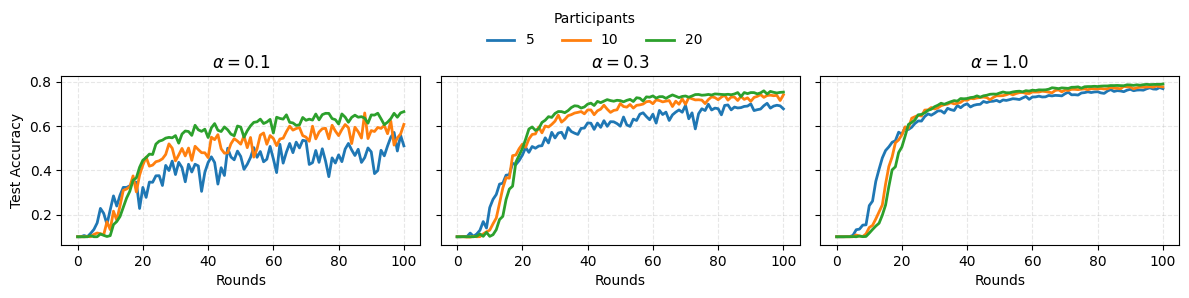

In [47]:
acc_pdf = plot_accuracy_grid(df_acc_rounds_mean, OUTPUT, save_pdf_name="accuracy_grid.pdf", show=True)

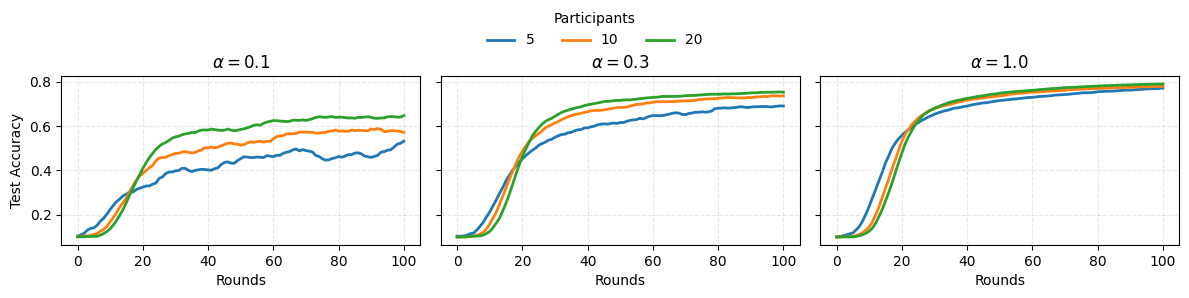

PosixPath('/home/filipe/Workspace/dynff/experiments/motivational/figs/acc_grid_smooth.pdf')

In [58]:
plot_accuracy_grid_smooth(df_acc_rounds_mean, OUTPUT,
                          save_pdf_name="acc_grid_smooth.pdf",
                          smooth=True, window=10, method="rolling", polyorder=2)

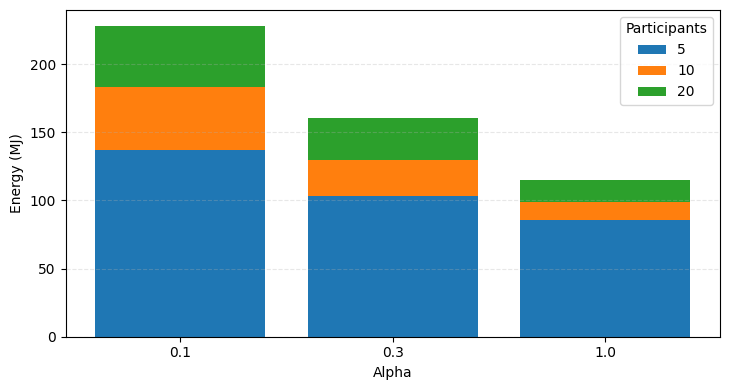

In [48]:
en_path = plot_stacked_diffs_MJ(totals_energy, OUTPUT, "energy_consumption.pdf", legend_title="Participants", show=True)

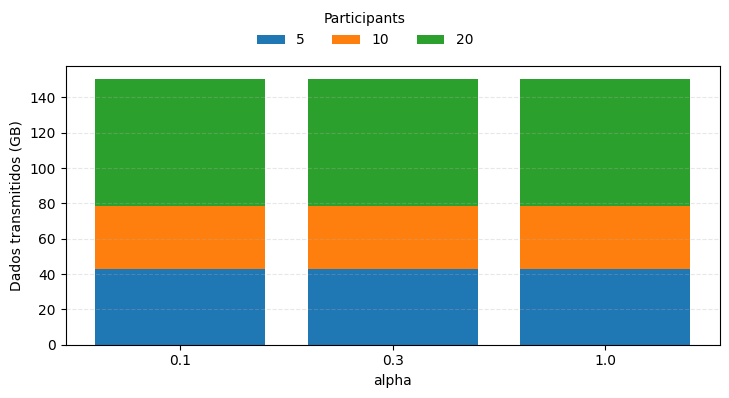

In [54]:
bytes_mb_pdf = plot_stacked_diffs_GB(totals_bytes, OUTPUT, "bytes_MB.pdf",
                                     legend_title="Participants", show=True)

# Takeways

    1 - O aumento da quantidade de participantes é proporcionalmente necessário ao nível de niid. (Incremento proporcional ao NIID)
    2 - Um piso de participação mais alto proporcionalmente ao nível de niid. (Decremento limitado ao NIID)
    3 - Modelos com partida fria tendem a melhorar o desempenho nas rodadas iniciais com menos clientes (Cold start + initial rounds)*
    * Opcional    

Conclusão prévia:

     - A solução tenderá a economizar mais em iid. 
     - A variação da participação tende a aumentar os custos.
     - Qualquer solução proposta será no intuito de mitigar danos.
  